<a href="https://colab.research.google.com/github/md6113/learnfastAI/blob/master/learnfastAI_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-Up

This workbook is to try out the fastai platform for image classification. I will try to classify 3 different plant types: 

Bloodleaf  
Coleus  
Caladium

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
folder = 'bloodleaf'
file = 'bloodleaf.csv'

In [0]:
folder = 'caladium'
file = 'caladium.csv'

In [0]:
folder = 'coleus'
file = 'coleus.csv'

In [0]:
path = 0
path = Path('data/colouredPlants')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

Upload csv files of image URLS then move them to the right folder

In [0]:
shutil.move("/content/bloodleaf.csv", "/content/data/colouredPlants/")
shutil.move("/content/caladium.csv", "/content/data/colouredPlants/")
shutil.move("/content/coleus.csv", "/content/data/colouredPlants/")

double check correct paths

In [0]:
path.ls()

In [0]:
classes = ['bloodleaf','caladium','coleus']

# Get Data

I retrieved my images from Google Images using the following Javascript command taken from the fastai tutorial:  

"urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));"

In [0]:
fullpath = path/file
download_images(fullpath, dest, max_pics=500)

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.show_batch(rows=3, figsize=(7,8))

double check variables are in good order

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

# Make a learner

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [47]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.071269,0.564176,0.238298,00:13
1,0.723153,0.377389,0.131915,00:13
2,0.567505,0.332288,0.144681,00:13
3,0.473097,0.332439,0.144681,00:13


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


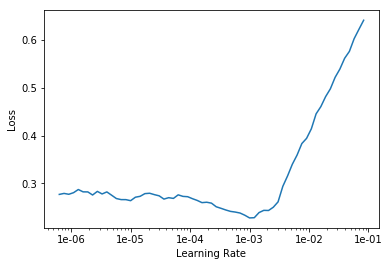

In [51]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(6, max_lr=slice(4e-3,2e-4))
learn.save('stage-3')

# Evaluate the learner

In [0]:
learn.load('stage-3');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.plot_confusion_matrix()

# Round 2

Remove bad images

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

The image cleaner widget doesn't work in colab, so I took 20 mins or so and inspected the datasets by hand. The bloodleaf dataset had a number of bad/unrelated images. I removed those I found.

After removing some images I retrained the classifier as 'stage-3'.

The effect of this removal did not help the classifier. Instead, it made it worse. This is likely because of the fact that most of the removed images were similar, and the classifier now is randomly assigning them to classes as opposed to the one it came from from (but shouldn't be present in)

In [0]:
# ImageCleaner(ds, idxs, path)
ImageCleaner??

# Example on how to export to prod

All that is needed is the export command to get a copy of the model in a .pkl file. After this all that is needed is to load the learner back in and pass it an image file.

In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class